In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [3]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Concatenate, Add, Multiply,Average, Subtract
from tensorflow.keras.models import Model
import traffic_data_generator
import traffic_util

Fix the random seeds in numpy, tensorlfow

In [4]:
import random as rn

rand_seed=116
rn.seed(rand_seed)
np.random.seed(rand_seed)
tf.random.set_seed(rand_seed)


In [5]:
example_name="traffic"
data_dir=traffic_data_generator.set_up(example_name)

In [6]:
Delta=0.1
n_var=3
domain_u=np.array([[-35,17], [.2, 2.],[0,.4]])
#Number of traning data and test data
n_samples=200000
n_train=100000
n_test=40000

In [7]:
#==============================
#  Structure of Neural Network
#==============================
input_d=n_var
output_d=n_var

In [8]:
#===========================
#     Output directories 
#===========================
experiment_name="_no_share"+ \
     "_"+str(n_train)+"_Delta_"+str(Delta)


model_dir=example_name+"/"+experiment_name
plot_dir=model_dir+"/Plots"
checkpoint_dir=model_dir+"/check_points"

if not os.path.exists(model_dir):
    os.mkdir(model_dir)
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

In [9]:
class Xing_1995 ():
    def __init__(self,delta_t,T1,T2):
        self.alpha=.5
        self.beta=.05
        self.T1=T1
        self.T2=T2
        self.delta_t=delta_t
        
    def acc_func(self,v,x):
        T1_n_steps=int(round(self.T1/self.delta_t))
        T2_n_steps=int(round(self.T2/self.delta_t))
        i_T1=np.max([v.shape[1]-T1_n_steps,0])
        i_T2=np.max([x.shape[1]-T2_n_steps,0])
        delta_v=v[0,i_T1]-v[1,i_T1]
        delta_x=x[0,i_T2]-x[1,i_T2]
        D_n=7+.5*v[1,i_T2]
        return self.alpha*delta_v+self.beta*(delta_x-D_n)

In [229]:
class GHR ():
    def __init__(self, c, m,l,T1,T2):
        self.c=c
        self.m=m
        self.l=l
        self.T1=T1
        self.T2=T2
        
    def acc_func(self,v,delta_x, delta_v):
        T1_n_steps=int(round(self.T1/self.delta_t))
        T2_n_steps=int(round(self.T2/self.delta_t))
        i_T1=np.max([v.shape[1]-T1_n_steps,0])
        i_T2=np.max([x.shape[1]-T2_n_steps,0])
        delta_v=v[0,i_T1]-v[1,i_T1]
        delta_x=x[0,i_T2]-x[1,i_T2]
        if abs(delta_x)<10**-12:
            delta_x=10**-12
        return v[0,0]**self.m*self.c*delta_v/delta_x**self.l

In [267]:
class Helbing ():
    def __init__(self,V_0,tau,V_e,s,R,tau_prime,T1,T2,delta_t):
        self.V_0=V_0
        self.tau=tau
        self.V_e=V_e
        self.s=s
        self.R=R
        self.tau_prime=tau_prime
        self.T1=T1
        self.T2=T2
        self.delta_t=delta_t
        
    def acc_func(self,v,x):
        T1_n_steps=int(round(self.T1/self.delta_t))
        T2_n_steps=int(round(self.T2/self.delta_t))
        i_T1,i_T2=None,None
        if len(v.shape)==2: i_T1=np.max([v.shape[1]-T1_n_steps-1,0])
        if len(x.shape)==2: i_T2=np.max([x.shape[1]-T2_n_steps-1,0])
        if len(v.shape)==2: v_current=v[0,0]
        else: v_current=v[0]
        delta_v=v[0,i_T1]-v[1,i_T1]
        delta_x=x[0,i_T2]-x[1,i_T2]
        return (self.V_e(delta_x)-v_current)/self.tau-np.exp((delta_x-s(v_current))/-self.R)*(-delta_v/self.tau_prime)*(-delta_v>0)

In [523]:
delta_gen=.01 #time step
traj_len=30 # total time 
separation_mean=400 # in cars/foot
loc_init='equal_space'
n_cars=20

lead_car_speed=60
vel_init='uniform'
vel_init_mean=50
vel_init_var=1

# c=19.8 # in feet/second
# m=0
# l=1
# T1=1.0
# T2=1.0
# acc_function=GHR(c,m,l).acc_func

# T1=.83
# T2=3.43
# acc_function=Xing_1995(delta_gen,T1,T2).acc_func

V_0=60
tau1=.3
def V_e(x): return V_0*(np.tanh(x-2)+np.tanh(2))
car_length=16
def s(v): return car_length+v*4 #this is an implementation of the 4 second following rule
R=50
tau2=.01
T1=0
T2=0

acc_function=Helbing(V_0,tau1,V_e,s,R,tau2,T1,T2,delta_gen).acc_func


In [524]:
x_length= int(round((n_cars-1)*separation_mean))
n_t_steps_traj=int(round(traj_len/delta_gen))
T1_n_steps=int(round(T1/delta_gen))
T2_n_steps=int(round(T2/delta_gen))

loc_matrix = np.zeros([n_cars,n_t_steps_traj])
if loc_init=='equal_space':
    loc_matrix[:,0] = np.arange(n_cars-1,-1,-1)*separation_mean
elif loc_init=='uniform':
    loc_matrix[:,0] = np.sort(np.random.uniform(0,x_length,n_cars))[::-1]
    loc_matrix[0,0] = x_length
    for i_car in range(n_cars-1):
        if abs(loc_matrix[i_car,0]-loc_matrix[i_car+1,0])<10*T*c:
            loc_matrix[i_car+1,0]=loc_matrix[i_car,0]-10*T*c
    
vel_matrix = np.zeros([n_cars,n_t_steps_traj])
if vel_init=='uniform':
    vel_matrix[:,0]=np.random.uniform(vel_init_mean-np.sqrt(vel_init_var*3),vel_init_mean+np.sqrt(vel_init_var*3),n_cars)
elif vel_init=='constant':
    vel_matrix[:,0]=np.ones(n_cars)*vel_init_mean
elif vel_init=='normal':
    vel_matrix[:,0]=np.max([np.zeros(n_cars),np.random.normal(vel_init_mean,vel_init_var,n_cars)],axis=0)
acc_matrix = np.zeros([n_cars,n_t_steps_traj])
#loc_matrix(:,1) = sort(rand(n,1),'descend')*40;


time = np.arange(n_t_steps_traj)*delta_gen

# first_car_loc =x_length;
# first_car_vel = sin(time)+2;
# first_car_acc = cos(time);

first_car_loc = x_length+lead_car_speed*time
first_car_vel = lead_car_speed+0*time
first_car_acc = 0*time

loc_matrix[0,:] = first_car_loc
vel_matrix[0,:] = first_car_vel
acc_matrix[0,:] = first_car_acc



for i in range(n_t_steps_traj-1):
    i_T1=np.max([i-T1_n_steps,0])
    i_T2=np.max([i-T2_n_steps,0])
    for j in range(1,n_cars):
        acc_matrix[j, i+1] = acc_function(vel_matrix[j-1:j+1,i_T1:i+1],
                                          loc_matrix[j-1:j+1,i_T1:i+1])
        vel_matrix[j, i+1] = vel_matrix[j, i] + acc_matrix[j, i+1]*delta_gen
        loc_matrix[j, i+1] = loc_matrix[j, i] + vel_matrix[j, i]*delta_gen + acc_matrix[j, i+1]*delta_gen**2/2
        
for i in range(1,n_cars):
    loc_matrix[i,:] -= loc_matrix[0,:]   
loc_matrix[0,:] -= loc_matrix[0,:]  

In [525]:
np.arange(n_cars-1,-1,-1)

array([19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,
        2,  1,  0])

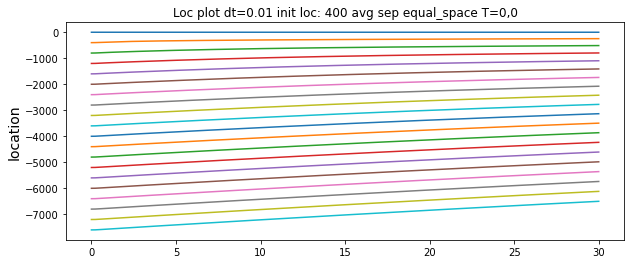

In [526]:
plt.figure(figsize=(10,4))
for i in range(n_cars):
    plt.plot(time,loc_matrix[i,:])
# plt.ylim(-400,20)
plt.title('Loc plot dt=' + str(delta_gen) + ' init loc: ' + str(separation_mean) + ' avg sep ' + loc_init +
#           ' dist init vel: '+ vel_init + "(" + str(vel_init_mean) + ' ,' + str(vel_init_var) + ")"+
          " T=" + str(T1) + "," +str(T2))
# plt.xlabel('time in seconds', fontsize=14)
plt.ylabel('location', fontsize=14)
plt.show()

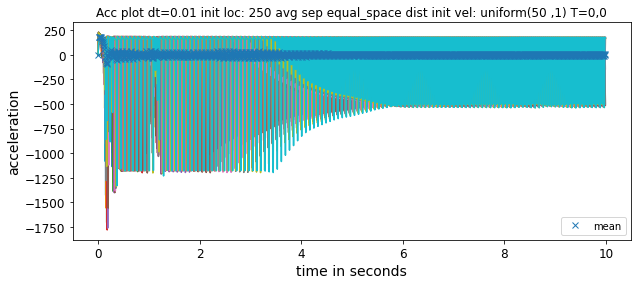

In [377]:
plt.figure(figsize=(10,4))
for i in range(n_cars):
    plt.plot(time,acc_matrix[i,:])
plt.plot(time,np.mean(acc_matrix,axis=0),'x',label='mean')
plt.title('Acc plot dt=' + str(delta_gen) + ' init loc: ' + str(separation_mean) + ' avg sep ' + loc_init +
          ' dist init vel: '+ vel_init + "(" + str(vel_init_mean) + ' ,' + str(vel_init_var) + ")"+
          " T=" + str(T1) + "," +str(T2))
plt.xlabel('time in seconds', fontsize=14)
plt.ylabel('acceleration', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.show()

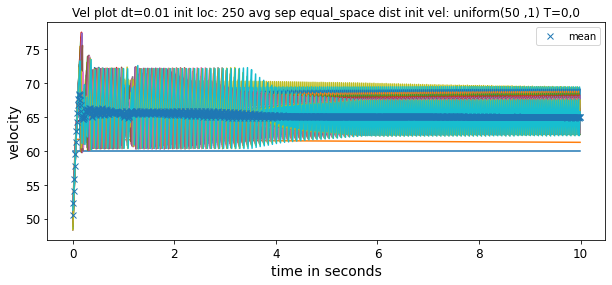

In [378]:
plt.figure(figsize=(10,4))
for i in range(n_cars):
    plt.plot(time,vel_matrix[i,:])
plt.plot(time,np.mean(vel_matrix,axis=0),'x',label='mean')
plt.title('Vel plot dt=' + str(delta_gen) + ' init loc: ' + str(separation_mean) + ' avg sep ' + loc_init +
          ' dist init vel: '+ vel_init + "(" + str(vel_init_mean) + ' ,' + str(vel_init_var) + ")"+
          " T=" + str(T1) + "," +str(T2))
plt.xlabel('time in seconds', fontsize=14)
plt.ylabel('velocity', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(50,60)
plt.legend()
plt.show()

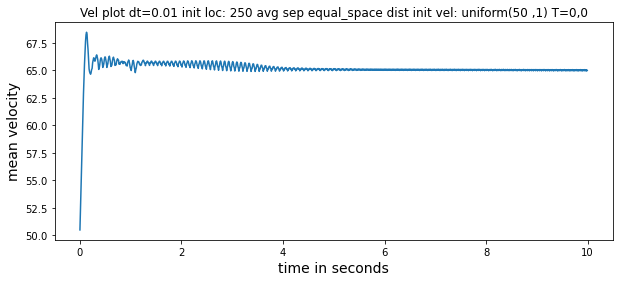

In [379]:
plt.figure(figsize=(10,4))
plt.plot(time,np.mean(vel_matrix,axis=0))
plt.xlabel('time in seconds', fontsize=14)
plt.ylabel('mean velocity', fontsize=14)
plt.title('Vel plot dt=' + str(delta_gen) + ' init loc: ' + str(separation_mean) + ' avg sep ' + loc_init +
          ' dist init vel: '+ vel_init + "(" + str(vel_init_mean) + ' ,' + str(vel_init_var) + ")"+
          " T=" + str(T1) + "," +str(T2))
plt.show()

In [518]:
#This returns an array with first column the location of the start of the bin, the second column as the density (number of cars)
#in that bin and the third as the average velocity of the cars in that bin. 
#NOTE the last entry for column 2 and 3 is always zero to allow us to define intervals well.
def indicator_func(x,v,bin_size,n_bins):
    bin_matrix=np.zeros([3,n_bins+1])
    bin_matrix[0]=-np.arange(n_bins+1)*bin_size
    ind=np.argsort(x)[::-1]
    bin_indicator=np.ceil(x[ind]/bin_size)
    v_sorted=v[ind]
    bin_end=np.zeros(n_bins+1,dtype=int)
    for i_bin in range(1,n_bins+1):
        bin_end[i_bin]=bin_end[i_bin-1]
        if -i_bin+1 in bin_indicator:
            bin_end[i_bin]=np.where(bin_indicator==-i_bin+1)[0][-1]
            bin_matrix[1,i_bin-1]=bin_end[i_bin]-bin_end[i_bin-1]+(i_bin==1)
            bin_matrix[2,i_bin-1]=np.mean(v_sorted[bin_end[i_bin-1]:bin_end[i_bin]+1])
    return bin_matrix
    
    

In [519]:
indicator_func(loc_matrix[:,0],vel_matrix[:,0],1056,8)

array([[ 0.00000000e+00, -1.05600000e+03, -2.11200000e+03,
        -3.16800000e+03, -4.22400000e+03, -5.28000000e+03,
        -6.33600000e+03, -7.39200000e+03, -8.44800000e+03],
       [ 3.00000000e+00,  3.00000000e+00,  2.00000000e+00,
         3.00000000e+00,  3.00000000e+00,  2.00000000e+00,
         3.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 5.25802806e+01,  4.99054335e+01,  5.08627260e+01,
         4.93054509e+01,  4.92748777e+01,  4.96095993e+01,
         4.95449095e+01,  4.96333853e+01,  0.00000000e+00]])

In [538]:
n_bin_time_step=traj_len
delta_t_bin=1
n_bins=7
bin_size=1056
histogram_matrix=np.zeros([n_bin_time_step,3,n_bins+1])
for i_bin_time in range(n_bin_time_step):
    bin_time_int=int(round(delta_t_bin/delta_gen))*i_bin_time
    histogram_matrix[i_bin_time,:,:]=indicator_func(loc_matrix[:,bin_time_int],vel_matrix[:,bin_time_int],bin_size,n_bins)

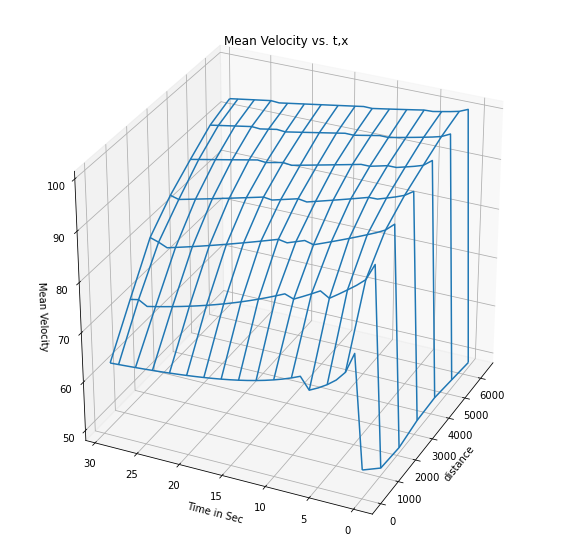

In [539]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

_x = np.arange(n_bin_time_step)*delta_t_bin
_y = np.arange(n_bins+1)*bin_size
_xx, _yy = np.meshgrid(_x, _y)

ax.plot_wireframe(_yy[:n_bins,:],_xx[:n_bins,:],np.transpose(histogram_matrix[:,2,:n_bins]), rstride=1, cstride=2)
ax.view_init(30, 205)
ax.set_xlabel('distance')
ax.set_ylabel('Time in Sec')
ax.set_zlabel('Mean Velocity')
ax.set_title('Mean Velocity vs. t,x')
plt.show()

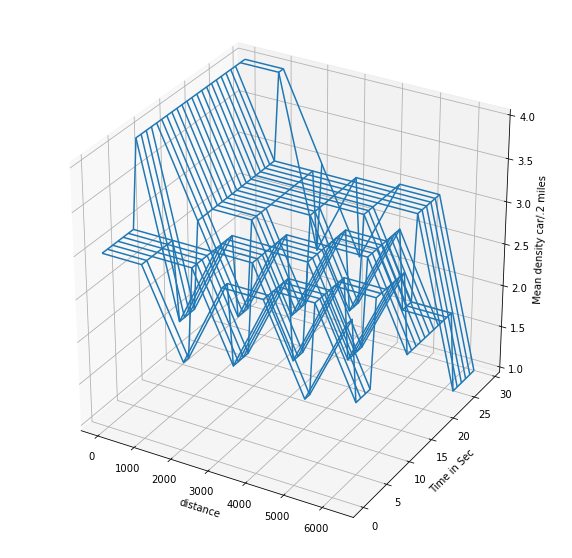

In [542]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(_yy[:n_bins,:],_xx[:n_bins,:],np.transpose(histogram_matrix[:,1,:n_bins]), rstride=1, cstride=1)
ax.view_init(30, 300)
ax.set_xlabel('distance')
ax.set_ylabel('Time in Sec')
ax.set_zlabel('Mean density car/.2 miles')
plt.show()

In [493]:
histogram_matrix[]

array([[[ 0.00000000e+00, -1.05600000e+03, -2.11200000e+03,
         -3.16800000e+03, -4.22400000e+03, -5.28000000e+03,
         -6.33600000e+03],
        [ 4.00000000e+00,  4.00000000e+00,  3.00000000e+00,
          4.00000000e+00,  3.00000000e+00,  2.00000000e+00,
          0.00000000e+00],
        [ 5.24772564e+01,  4.94064259e+01,  5.00052901e+01,
          4.94878244e+01,  5.04736319e+01,  4.93805528e+01,
          0.00000000e+00]],

       [[ 0.00000000e+00, -1.05600000e+03, -2.11200000e+03,
         -3.16800000e+03, -4.22400000e+03, -5.28000000e+03,
         -6.33600000e+03],
        [ 4.00000000e+00,  4.00000000e+00,  3.00000000e+00,
          4.00000000e+00,  3.00000000e+00,  2.00000000e+00,
          0.00000000e+00],
        [ 6.52305066e+01,  7.24737127e+01,  7.65292506e+01,
          7.92624962e+01,  7.90636382e+01,  7.63206538e+01,
          0.00000000e+00]],

       [[ 0.00000000e+00, -1.05600000e+03, -2.11200000e+03,
         -3.16800000e+03, -4.22400000e+03, -5.28000000

In [173]:
a=(def log(x): return np.log(x))

SyntaxError: invalid syntax (<ipython-input-173-c3ef5cc084e3>, line 1)

In [172]:
a(3)

1.0986122886681098